In [2]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

import yfinance as yf
from typing import List
from pandas_datareader import data as pdr

from matplotlib import pyplot as plt

pd.options.mode.chained_assignment = None

# Sentiment Data Cleaning

In [3]:
file = 'basic_data/tweets_new.csv'
df = pd.read_csv(file, index_col=None, lineterminator='\n', header=0, names=['Datetime', 'Clean_Text', 'Text', 'Subjectivity', 'Polarity', 'Sentiment'], dtype='unicode')
raw_data = df[['Datetime','Subjectivity', 'Polarity', 'Sentiment']]
POLARITY, SENTIMENT = "Polarity", "Sentiment"
raw_data

,Datetime,Subjectivity,Polarity,Sentiment
0,2021-10-25 16:02:34+00:00,0.41818181818181815,0.5454545454545454,POSITIVE
1,2021-10-25 14:36:53+00:00,0.0,0.0,NEUTRAL
2,2021-10-25 13:06:23+00:00,0.0,0.0,NEUTRAL
3,2021-10-24 11:54:44+00:00,0.2772727272727273,0.06818181818181818,POSITIVE
4,2021-10-23 19:03:00+00:00,0.0,0.0,NEUTRAL
...,...,...,...,...
246381,2021-10-22 13:54:20+00:00,0.0,0.0,NEUTRAL
246382,2021-10-22 13:42:46+00:00,0.7555555555555555,0.03333333333333336,POSITIVE
246383,2021-08-23 18:53:01+00:00,0.0,0.0,NEUTRAL
246384,2018-09-06 22:12:41+00:00,0.1,0.0,NEUTRAL


In [4]:
raw_data["Datetime"] = pd.to_datetime(raw_data["Datetime"]).dt.date
raw_data[POLARITY] = raw_data[POLARITY].astype('float')

In [5]:
POSITIVE_THRESHOLD = 0.5
NEGATIVE_THRESHOLD = -0.5
POSITIVE, NEUTRAL, NEGATIVE = 'Positive', 'Neutral', 'Negative'

conditions = [(raw_data[POLARITY] > POSITIVE_THRESHOLD),
              (raw_data[POLARITY] < NEGATIVE_THRESHOLD)]
raw_data[SENTIMENT] = np.select(conditions, [POSITIVE, NEGATIVE], default=NEUTRAL)

In [6]:
result =  pd.pivot_table(raw_data[["Datetime", SENTIMENT]],
                          index='Datetime', columns=SENTIMENT, aggfunc=len, fill_value=0)
normalized_result = result.div(result.sum(axis=1), axis=0)[["Positive", "Negative"]]

In [7]:
normalized_result

Sentiment,Positive,Negative
Datetime,,
2017-01-01,0.021739,0.043478
2017-01-02,0.028169,0.000000
2017-01-03,0.069444,0.000000
2017-01-04,0.076577,0.013514
2017-01-05,0.044118,0.018382
...,...,...
2021-10-21,0.008850,0.013274
2021-10-22,0.004950,0.004950
2021-10-23,0.010204,0.040816


In [34]:
start_date = normalized_result.head(1).index.values[0]
end_date = normalized_result.tail(1).index.values[0]

# Get Financial Data

In [9]:
def get_financial_time_series(symbol: str, start_date: str, end_date: str,
                              type: List[str] = ('Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume')):
    return pdr.get_data_yahoo(symbol, start=start_date, end=end_date)[type]


def get_returns_time_series(symbol: str, start_date: str, end_date: str):
    close_price = get_financial_time_series(symbol, start_date, end_date, ["Close"])
    return np.log1p(close_price["Close"].pct_change()).dropna()

In [35]:
financial_data = get_returns_time_series("^GSPC", start_date, end_date)
full_data = normalized_result.join(financial_data)[["Close", POSITIVE, NEGATIVE]].dropna()
full_data

,Close,Positive,Negative
Datetime,,,
2017-01-04,0.005706,0.076577,0.013514
2017-01-05,-0.000771,0.044118,0.018382
2017-01-06,0.003511,0.050228,0.018265
2017-01-09,-0.003555,0.041885,0.000000
2017-01-10,0.000000,0.069767,0.011628
...,...,...,...
2021-10-19,0.007366,0.032086,0.000000
2021-10-20,0.003657,0.024896,0.000000
2021-10-21,0.002991,0.008850,0.013274


# Selecting ARIMAX Model
From the code below, seems that only negative sentiments are statistically significant enough for consideration as an external regressor, hence we remove positive sentiments from the model.

In [12]:
def get_best_model(returns, external=None):
    """
    Uses the Akaike Information Criteria (AIC) to select best order of ARMA model
    :param training_data: Training data
    :return: Params for the order
    """
    best_aic = np.inf
    best_order = None
    best_mdl = None

    pq_rng = range(5)
    for i in pq_rng:
        for j in pq_rng:
            if external is None:
                tmp_mdl = smt.ARIMA(endog=returns, order=(i, 0, j)).fit()
            else:
                tmp_mdl = smt.ARIMA(endog=returns, exog=external, order=(i, 0, j)).fit()
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic, best_order = tmp_aic, (i, 0, j)
                best_mdl = tmp_mdl
    return best_order, best_mdl

In [13]:
best_order, best_mdl = get_best_model(financial_sediment_join["Close"].values)

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros 

In [14]:
best_order_sentiment, best_mdl_sentiment = get_best_model(financial_sediment_join["Close"].values, financial_sediment_join[[POSITIVE, NEGATIVE]].values)

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting pa

In [15]:
best_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1176
Model:                 ARIMA(3, 0, 1)   Log Likelihood                3577.836
Date:                Fri, 05 Nov 2021   AIC                          -7143.672
Time:                        00:44:44   BIC                          -7113.253
Sample:                             0   HQIC                         -7132.202
                               - 1176                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.552      0.121      -0.000       0.001
ar.L1         -1.0810      0.020    -54.115      0.000      -1.120      -1.042
ar.L2         -0.0495      0.021     -2.399      0.016      -0.090      -0.009
ar.L3          0.2208      0.013     17.066      0.000       0.195       0.246
ma.L1          0.8971      0.017     53.384      0.000       0.864       0.930
sigma2         0.0001   2.22e-06     59.866      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):              8612.54
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               5.24   Skew:                            -1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
best_mdl_sentiment.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1176
Model:                 ARIMA(4, 0, 4)   Log Likelihood                3559.740
Date:                Fri, 05 Nov 2021   AIC                          -7095.480
Time:                        00:44:44   BIC                          -7034.642
Sample:                             0   HQIC                         -7072.540
                               - 1176                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.121      0.262      -0.001       0.002
x1             0.0030      0.015      0.202      0.840      -0.026       0.032
x2            -0.0895      0.027     -3.345      0.001      -0.142      -0.037
ar.L1         -0.6782      0.115     -5.893      0.000      -0.904      -0.453
ar.L2          0.2517      0.102      2.467      0.014       0.052       0.452
ar.L3         -0.3736      0.054     -6.973      0.000      -0.479      -0.269
ar.L4         -0.4298      0.043    -10.084      0.000      -0.513      -0.346
ma.L1          0.4664      0.118      3.961      0.000       0.236       0.697
ma.L2         -0.1700      0.077     -2.222      0.026      -0.320      -0.020
ma.L3          0.6303      0.044     14.283      0.000       0.544       0.717
ma.L4          0.3369      0.051      6.587      0.000       0.237       0.437
sigma2         0.0001   2.58e-06     53.105      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):             10261.76
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               5.08   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
best_order_neg, best_mdl_neg = get_best_model(financial_sediment_join["Close"].values, financial_sediment_join[NEGATIVE].values)

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros 

In [18]:
best_mdl_neg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1176
Model:                 ARIMA(4, 0, 3)   Log Likelihood                3561.587
Date:                Fri, 05 Nov 2021   AIC                          -7103.175
Time:                        00:45:09   BIC                          -7052.476
Sample:                             0   HQIC                         -7084.058
                               - 1176                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.352      0.001       0.001       0.002
x1            -0.0620      0.024     -2.547      0.011      -0.110      -0.014
ar.L1         -0.1309      0.038     -3.418      0.001      -0.206      -0.056
ar.L2          0.3764      0.063      6.011      0.000       0.254       0.499
ar.L3         -0.2786      0.050     -5.602      0.000      -0.376      -0.181
ar.L4         -0.3882      0.016    -23.784      0.000      -0.420      -0.356
ma.L1         -0.0860      0.044     -1.954      0.051      -0.172       0.000
ma.L2         -0.2320      0.056     -4.146      0.000      -0.342      -0.122
ma.L3          0.4168      0.050      8.267      0.000       0.318       0.516
sigma2         0.0001   2.37e-06     56.012      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   2.35   Jarque-Bera (JB):             10905.46
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               4.87   Skew:                            -1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Testing Model

We look back 252 points of data to construct a temporary model to project for the next point using the external regressor.

There is a marginal increase in performance (predicting movement) when the negative sentiments are considered. Keep in mind however that we assume that we can get approximate sentiment for the same day. This is because the p-value of the regression when taking the lagged term is not low enough to reject the hypothesis that they have no relationship.

This suggests the time-sensitivity of tweets; information based on tweets does not linger for too long, suggesting that such strategies probably needs data of a much shorter investment horizon (eg: 15 minute basis instead of dailyt)

In [60]:
training_size = 50
training_return, training_negative = full_data["Close"].iloc[:-training_size], full_data["Negative"].iloc[:-training_size]

In [61]:
def evaluate_model(returns, external=None):
    best_order, _ = get_best_model(returns, external)
    prediction = []
    for index, i in enumerate(range(-training_size, 0, 1)):
        training_data = full_data.iloc[i-500:i]
        if external is None:
            training_model = smt.ARIMA(endog=training_data["Close"], order=best_order).fit()
            prediction += [training_model.forecast().values[0]]
        else: 
            training_model = smt.ARIMA(endog=training_data["Close"], exog=training_data["Negative"].values, order=best_order).fit()
            prediction += [training_model.forecast(exog=full_data["Negative"].iloc[index]).values[0]]
    return prediction

In [62]:
prediction_list = evaluate_model(training_return)

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-pac

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-pac

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-pac

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

In [63]:
prediction_list_negative = evaluate_model(training_return, training_negative)

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-pac

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-pac

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\t

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\t

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provide

In [64]:
actual = full_data["Close"].tail(training_size).values

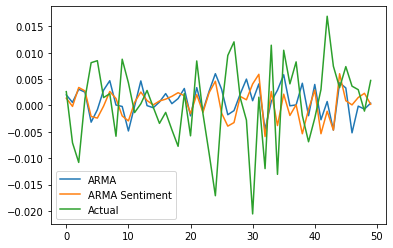

In [65]:
plt.plot(prediction_list, label='ARMA')
plt.plot(prediction_list_negative, label='ARMA Sentiment')
plt.plot(actual, label='Actual')
plt.legend()
plt.show()

In [66]:
arma_positive = np.array(prediction_list) > 0
arma_sentiment_positive = np.array(prediction_list_negative) > 0
actual_positive = np.array(actual) > 0

In [67]:
sum(arma_positive == actual_positive)/100

0.23

In [68]:
sum(arma_sentiment_positive == actual_positive)/100

0.25